In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [86]:
class SoccerGame():
    
    def __init__(self,train=True,seed=None):
        self.own_goal_reward = -100
        self.goal_reward = +100
        self.state_space = np.array([[1,2,3,4],[5,6,7,8]])
        self.goal_dict = {1:'Player A', 5:'Player A', 4: 'Player B',8:'Player B'}
        self.goal_states = [1,4,5,8]
        self.non_goal_states = [2,3,6,7]
        self.nA = 5
        self.action_space = [0,1,2,3,4]
        self.enable_train = train
        self.player_a_pos,self.player_b_pos = self.initalize_player_positions()
        self.possesion = self.initalize_ball_possesion()
        self.time_step = 0
        self.episode_counter = 0
        self.player_a_rewards = []
        self.player_b_rewards = []
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
    
    def go_east(self,current_position):
        if current_position in [4,8]:
            return current_position
        else:
            return current_position+1
        
    def go_west(self,current_position):
        if current_position in [1,5]:
            return current_position
        else:
            return current_position-1
        
    def go_north(self,current_position):
        if current_position in [1,2,3,4]:
            return current_position
        else:
            return current_position - 4
        
    def go_south(self,current_position):
        if current_position in [5,6,7,8]:
            return current_position
        else:
            return current_position + 4
        
    def go_noop(self,current_position):
        return current_position
    
    def test_action(self,action,current_position):
        if action == 1:
            return self.go_north(current_position)
        elif action == 2:
            return self.go_east(current_position)
        elif action == 3:
            return self.go_south(current_position)
        elif action == 4:
            return self.go_west(current_position)
        else:
            return self.go_noop(current_position)
            

    
    def get_goal_rewards(self):
        if self.player_a_pos in self.goal_states and self.possesion == 'Player A':
            player_goal = self.goal_dict[self.player_a_pos]
            if player_goal == 'Player A':
                ##proper goal
                reward_a = self.goal_reward
                reward_b = -1*reward_a
            else:
                #a scored an own goal
                reward_a = self.own_goal_reward
                reward_b = -1*reward_a
            return reward_a,reward_b
        
        elif self.player_b_pos in self.goal_states and self.possesion == 'Player B':
            player_goal = self.goal_dict[self.player_b_pos]
            if player_goal == 'Player B':
                ##proper goal
                reward_b = self.goal_reward
                reward_a = -1*reward_b
            else:
                #a scored an own goal
                reward_b = self.own_goal_reward
                reward_a = -1*reward_b
            return reward_a,reward_b
        
        else:
            print('Something has gone very wrong here')
            
    def check_terminal_state(self):
        if (self.player_a_pos in self.goal_states and self.possesion == 'Player A') or (self.player_b_pos in self.goal_states and self.possesion == 'Player B'):
            
            return True
        
        else:
            return False
        
    def determine_action_order(self):
        
        if np.random.rand() >= .5:
            return ['Player A','Player B']
        
        else:
            return ['Player B','Player A']
        
    def apply_step(self,player_name,action):
        self.time_step+=1
        if player_name == 'Player A':
            player_a_new_state = self.test_action(action=action,current_position=self.player_a_pos)
            if player_a_new_state == self.player_b_pos:
                #a collides with stationary b
                player_a_resolved_action = 0

                if self.possesion == 'Player A':
                    self.possesion = 'Player B'
                    
            else:
                player_a_resolved_action = action
                
            self.player_a_pos = self.test_action(action=player_a_resolved_action,current_position=self.player_a_pos)
            
        else:
            player_b_new_state = self.test_action(action=action,current_position=self.player_b_pos)
            if player_b_new_state == self.player_a_pos:
                #b collides with a
                player_b_resolved_action = 0
                if self.possesion == 'Player B':
                    self.possesion = 'Player A'
            else:
                player_b_resolved_action = action
            
            self.player_b_pos = self.test_action(action=player_b_resolved_action,current_position=self.player_b_pos)
            
            
    def reset_env(self):
        self.possesion = self.initalize_ball_possesion()
        self.episode_counter +=1
        self.time_step = 0
        self.player_a_pos, self.player_b_pos = self.initalize_player_positions()
        
    def initalize_ball_possesion(self):
        if self.enable_train:
            return 'Player B'
        else:
            if np.random.rand()>=.5:
                return 'Player A'
            else:
                return 'Player B'
        
    def initalize_player_positions(self):
        if self.enable_train:
            player_a_pos = 3
            player_b_pos = 2
        else:
            if np.random.rand() >= .5:
                player_b_pos = 2
            else:
                player_b_pos = 6

            if np.random.rand() >= .5:
                player_a_pos = 3
            else:
                player_a_pos = 7

        return player_a_pos,player_b_pos
    
    def step(self,player_a_action,player_b_action):
        if self.check_terminal_state():
            raise Exception('The game has already terminated need to reset before moving again')
            
     
        action_order = self.determine_action_order()
        
        if action_order[0] == 'Player A':
            self.apply_step('Player A',player_a_action)
            
            self.apply_step('Player B',player_b_action)
            if self.check_terminal_state():
                reward_a,reward_b = self.get_goal_rewards()
                self.player_a_rewards.append(reward_a)
                self.player_b_rewards.append(reward_b)
                done = True
                next_state = self.get_state()
                reward = (reward_a,reward_b)

            else:
                next_state = self.get_state()
                reward = (0,0)
                done = False
        
        else:
            self.apply_step('Player B',player_b_action)
            self.apply_step('Player A',player_a_action)
            if self.check_terminal_state():
                reward_a,reward_b = self.get_goal_rewards()
                done = True
                next_state = self.get_state()
                reward = (reward_a,reward_b)
                self.player_a_rewards.append(reward_a)
                self.player_b_rewards.append(reward_b)

            else:
                next_state = self.get_state()
                reward = (0,0)
                done = False
        
        return next_state, reward, done
    
    def get_state(self):
        return [self.player_a_pos,self.player_b_pos]
    
    
    def render(self):
        field = [["$A$", " ", " ", "$B$"],
                ["$A$", " ", " ", "$B$"]]
        
        
        state_array_codes = {1:[0,0],2:[0,1],3:[0,2],4:[0,3],5:[1,0],6:[1,1],7:[1,2],8:[1,3]}
        player_a_array_code = state_array_codes[self.player_a_pos]
        player_b_array_code = state_array_codes[self.player_b_pos]
    
        if self.possesion == 'Player B':
            field[player_a_array_code[0]][player_a_array_code[1]] = "a"
            field[player_b_array_code[0]][player_b_array_code[1]] = "B"
        elif self.possesion == 'Player A':
            field[player_a_array_code[0]][player_a_array_code[1]] = "A"
            field[player_b_array_code[0]][player_b_array_code[1]] = "b"

        line1 = " | ".join(e for e in field[0])
        line2 = " | ".join(e for e in field[1])

        out = "---------------------\n| {} |\n---------------------\n| {} |\n---------------------".format(line1, line2)
        print(out)

In [87]:
class QLearner():
    
    def __init__(self,env,seed=None,lin=True):
        
        self.max_iterations = 1000000
        self.gamma = 0.90
        self.min_epsilon = 0.001
        self.initial_epsilon = 1.0
        self.epsilon_schedule = np.linspace(start=self.initial_epsilon,stop=self.min_epsilon,num=1000000)
        #self.epsilon_schedule = np.repeat([1.0,0.001],[750000,250000])
        #self.epsilon_schedule = np.logspace(start=0,stop=-3,num=self.max_iterations,base=10, endpoint=True)
        self.current_epsilon = self.epsilon_schedule[0]
        self.initial_alpha = 1.0
        self.min_alpha = 0.001
        if lin:  
            self.alpha_schedule = np.linspace(start=self.initial_alpha,stop=self.min_alpha,num=self.max_iterations)
        else:
            self.alpha_schedule = np.logspace(start=0,stop=-2,num=self.max_iterations,base=10, endpoint=True)
        self.current_alpha = self.alpha_schedule[0]
        self.env = env
        self.nA = self.env.nA
        self.q_table = np.zeros((8,8,2,5))
        self.error_log = []
        self.iter_list = []
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
    
  
    def poss_to_int(self):
        poss = self.env.possesion
        if poss == 'Player A':
            poss_int = 0
        else:
            poss_int = 1
        return poss_int
        
    def e_greedy_action(self,old_p1_pos,old_p2_pos,old_poss_int):
        if self.current_epsilon >= np.random.rand():
            action = np.argmax(self.q_table[old_p1_pos,old_p2_pos,old_poss_int])
        else:
            action = np.random.randint(5)
        return action
        
    def train_loop(self):
        self.env.reset_env()
        done = False
        for i in range(self.max_iterations):
            old_poss_int = self.poss_to_int()
            old_p1_pos = self.env.player_a_pos - 1
            old_p2_pos = self.env.player_b_pos -1
            action_1 = self.e_greedy_action(old_p1_pos,old_p2_pos,old_poss_int)
            action_2 = np.random.randint(5)
            old_q_entry = self.q_table[old_p1_pos,old_p2_pos,old_poss_int,action_1]
            _, reward, done = self.env.step(action_1,action_2)
            new_poss_int = self.poss_to_int()
            new_p1_pos = self.env.player_a_pos - 1
            new_p2_pos = self.env.player_b_pos - 1
            reward_1 = reward[0]
            reward_2 = reward[1]
            self.q_table[old_p1_pos,old_p2_pos,old_poss_int,action_1] = (1-self.current_alpha)*self.q_table[old_p1_pos,old_p2_pos,old_poss_int,action_1]+self.current_alpha*((1-self.gamma)*reward_1+self.gamma*np.max(self.q_table[new_p1_pos,new_p2_pos,new_poss_int,:]))
            if (old_p1_pos,old_p2_pos,old_poss_int,action_1,action_2) == (2,1,1,3,0):
                new_q_entry = self.q_table[old_p1_pos,old_p2_pos,old_poss_int,action_1]
                error = np.abs(new_q_entry-old_q_entry)
                self.error_log.append(error)
                self.iter_list.append(i)
            self.current_alpha = self.alpha_schedule[i]
            self.current_epsilon = self.epsilon_schedule[i]
            if done:
                self.env.reset_env()
                done = False
                
            if i%10000 == 0:
                print('Iteration Number :',i)
                
    def error_plot(self):
        plt.plot(np.array(self.error_log))
        plt.show()


In [88]:
q_learn = QLearner(env=SoccerGame(train=False))

In [89]:
q_learn.train_loop()

Iteration Number : 0
Iteration Number : 10000
Iteration Number : 20000
Iteration Number : 30000
Iteration Number : 40000
Iteration Number : 50000
Iteration Number : 60000
Iteration Number : 70000
Iteration Number : 80000
Iteration Number : 90000
Iteration Number : 100000
Iteration Number : 110000
Iteration Number : 120000
Iteration Number : 130000
Iteration Number : 140000
Iteration Number : 150000
Iteration Number : 160000
Iteration Number : 170000
Iteration Number : 180000
Iteration Number : 190000
Iteration Number : 200000
Iteration Number : 210000
Iteration Number : 220000
Iteration Number : 230000
Iteration Number : 240000
Iteration Number : 250000
Iteration Number : 260000
Iteration Number : 270000
Iteration Number : 280000
Iteration Number : 290000
Iteration Number : 300000
Iteration Number : 310000
Iteration Number : 320000
Iteration Number : 330000
Iteration Number : 340000
Iteration Number : 350000
Iteration Number : 360000
Iteration Number : 370000
Iteration Number : 380000


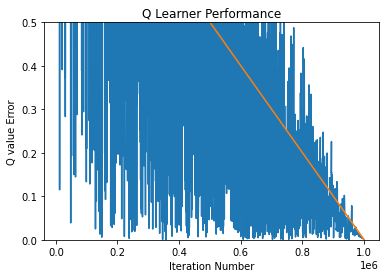

In [90]:
iter_num = np.array(q_learn.iter_list)
err = np.array(q_learn.error_log)
plt.plot(iter_num,err)
plt.plot(iter_num,q_learn.alpha_schedule[iter_num])
plt.ylim((0,.5))
plt.title('Q Learner Performance')
plt.ylabel('Q value Error')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xlabel('Iteration Number')
plt.show()

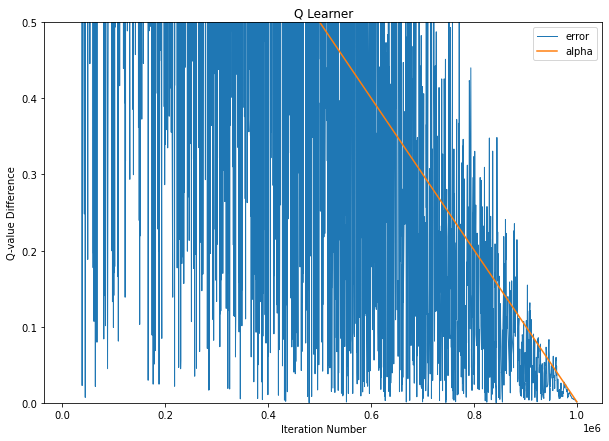

In [81]:
plt.figure(figsize=(10,7))
plt.plot(iter_num,err,linewidth=1,label = 'error')
plt.plot(iter_num,q_learn.alpha_schedule[iter_num],label='alpha')
plt.title('Q Learner')
plt.ylabel('Q-value Difference')
plt.xlabel('Iteration Number')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylim((0,0.5))
plt.legend()
#plt.savefig('Q_fin_2.jpg', bbox_inches='tight')

In [91]:
q_learn2 = QLearner(env=SoccerGame(train=False),lin=False)
q_learn2.train_loop()

Iteration Number : 0
Iteration Number : 10000
Iteration Number : 20000
Iteration Number : 30000
Iteration Number : 40000
Iteration Number : 50000
Iteration Number : 60000
Iteration Number : 70000
Iteration Number : 80000
Iteration Number : 90000
Iteration Number : 100000
Iteration Number : 110000
Iteration Number : 120000
Iteration Number : 130000
Iteration Number : 140000
Iteration Number : 150000
Iteration Number : 160000
Iteration Number : 170000
Iteration Number : 180000
Iteration Number : 190000
Iteration Number : 200000
Iteration Number : 210000
Iteration Number : 220000
Iteration Number : 230000
Iteration Number : 240000
Iteration Number : 250000
Iteration Number : 260000
Iteration Number : 270000
Iteration Number : 280000
Iteration Number : 290000
Iteration Number : 300000
Iteration Number : 310000
Iteration Number : 320000
Iteration Number : 330000
Iteration Number : 340000
Iteration Number : 350000
Iteration Number : 360000
Iteration Number : 370000
Iteration Number : 380000


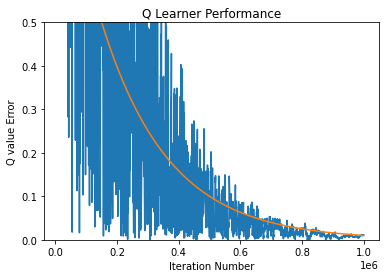

In [92]:
iter_num2 = np.array(q_learn2.iter_list)
err2 = np.array(q_learn2.error_log)
plt.plot(iter_num2,err2)
plt.plot(iter_num2,q_learn2.alpha_schedule[iter_num2])
plt.ylim((0,.5))
plt.title('Q Learner Performance')
plt.ylabel('Q value Error')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xlabel('Iteration Number')
plt.show()

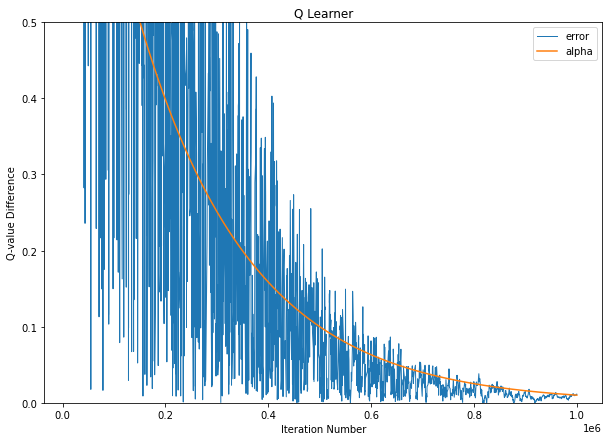

In [93]:
plt.figure(figsize=(10,7))
plt.plot(iter_num2,err2,linewidth=1,label = 'error')
plt.plot(iter_num2,q_learn2.alpha_schedule[iter_num2],label='alpha')
plt.title('Q Learner')
plt.ylabel('Q-value Difference')
plt.xlabel('Iteration Number')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylim((0,0.5))
plt.legend()
#plt.savefig('Q_fin_2.jpg', bbox_inches='tight')